# Project Proposal: Prediction of Heart Disease Using a Classification Model

Authors: Janie Holzmann, Riley McNair, Stephanie Ta, and Hayden Wai.

## Introduction

Heart disease is the second leading cause of death in Canada, and occurs due to a build up of plaque in a person’s arteries (Public Health Agency of Canada, 2022). It can lead to a heart attack, heart failure, or death. There are many factors that can increase a person's likelihood of getting diagnosed with heart disease, including high blood pressure, cholesterol levels, and physical inactivity (Centres for Disease Control and Prevention, 2020). With this project, we want to answer the question: **Can a person’s age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas accurately predict if they will get diagnosed with heart disease?** We will be using a dataset from the Cleveland Clinic Foundation from 1988, which includes these various attributes for 303 patients, and whether or not they were diagnosed with heart disease.

## Methods and Results

In [1]:
# load packages
library(tidyverse) # needed for many functions used for data analysis, such as read_csv(), select(), etc.
library(repr) # needed to resize plots
library(tidymodels) # needed to split data into training and testing data and to perform classification
library(cowplot) # needed to put plots side-by-side
set.seed(10) #set seed to make our data analysis reproducible

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The dataset can be obtained from UC Irvine's Machine Learning Repository: https://archive.ics.uci.edu/dataset/45/heart+disease via a zip file.

In [2]:
# read in dataset from web
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
download.file(url, "cleveland_data.zip")
unzip("cleveland_data.zip")
cleveland_original <- read_csv("processed.cleveland.data",
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                        "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                               show_col_types = FALSE)

# preview first 5 rows of the dataframe
head(cleveland_original, 5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


*Table 1: Preview of Cleveland dataframe.*

We cleaned the dataset to only contain information relevant to our analysis and converted a column's values to make more sense. Specifically, the dataset's description indicates that values 1, 2, 3, and 4 in the num column means that heart disease is present but does not indicate what differences in these values mean. So we converted num into a binary column (0 = no heart disease; 1 = presence of heart disease).

We first get rid of the columns we don't need so that we can focus on the columns corresponding to what we think can cause heart disease: 
* age (```age```)
* sex (```sex```)
* resting blood pressure (```trestbps```)
* cholesterol (```chol```)
* fasting blood sugar (```fbs```)
* exercised-induced angina (```exang```)

We also keep the column representing the actual heart disease diagnosis, ```num```, to use for training and testing our model.

In [3]:
# select for columns we'll use
cleveland <- select(cleveland_original, age, sex, trestbps, chol, fbs, exang, num)

# convert num column to binary factor (0 = no heart disease; 1 = presence of heart disease)
cleveland <- cleveland |>
    mutate(num = ifelse(num != 0, 1, 0)) |>
    mutate(num = as_factor(num))

# preview first 5 rows of new dataframe
head(cleveland, 5)

age,sex,trestbps,chol,fbs,exang,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,0,0
67,1,160,286,0,1,1
67,1,120,229,0,1,1
37,1,130,250,0,0,0
41,0,130,204,0,0,0


*Table 2: Preview of cleaned Cleveland dataframe.*

We then split our cleaned data into training and testing data, then performed exploratory data analysis on the training data.

In [4]:
cleveland_split <- initial_split(cleveland, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

To gain insight into our training data, the following data tables were made to see the number of observations in each class of sex, fasting blood sugar level, and if an individual gets exercise induced angina (chest pain).

In [5]:
# table for number of observations in each class of sex: (1 = male; 0 = female)
cleveland_train_sex <- cleveland_training |>
    group_by(sex) |>
    summarize(amount_of_individuals = n())

# table for number of observations in each class of fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
cleveland_train_fbs <- cleveland_training |>
    group_by(fbs) |>
    summarize(amount_of_individuals = n())

# table for number of observations in each class of exang: exercise induced angina (1 = yes; 0 = no)
cleveland_train_exang <- cleveland_training |>
    group_by(exang) |>
    summarize(amount_of_individuals = n())

In [6]:
cleveland_train_sex

sex,amount_of_individuals
<dbl>,<int>
0,72
1,155


*Table 3: Proportion of individuals in training set who are male (```sex = 1```) and female (```sex = 0```)*

In [7]:
cleveland_train_fbs

fbs,amount_of_individuals
<dbl>,<int>
0,190
1,37


*Table 4: Proportion of individuals in training set who have fasting blood sugar above 120 mg/dl (```fbs = 1``` if true, ```fbs = 0``` if false)*

In [8]:
cleveland_train_exang

exang,amount_of_individuals
<dbl>,<int>
0,157
1,70


*Table 5: Proportion of individuals in training set who experience exercise-induced angina (```exang = 1``` if true, ```exang = 0``` if false)*

We also found the means of our planned predictor variables:

In [9]:
cleveland_train_means <- cleveland_training |>
    select(-num) |>
    map_df(mean)

cleveland_train_means

age,sex,trestbps,chol,fbs,exang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.00441,0.6828194,131.4581,243.3084,0.1629956,0.30837


*Table 6: mean values of predictor variables.*

Additionally, we visualized the distributions of each numerical/non-binary predictor variables (age, resting blood pressure, and cholesterol level) in the following histograms:

In [10]:
# set size of the plots
options(repr.plot.height = 6, repr.plot.width = 7.5)

# distribution of age
age_dist <- cleveland_training |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 25) +
    labs(x = "Age (years)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Ages") +
    theme(text = element_text(size = 18))

# distribution of trestbps: resting blood pressure
trestbps_dist <- cleveland_training |>
    ggplot(aes(x = trestbps)) +
    geom_histogram(bins = 25) +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Resting Blood Pressures") +
    theme(text = element_text(size = 18))

# distribution of chol: serum cholesterol
chol_dist <- cleveland_training |>
    ggplot(aes(x = chol)) +
    geom_histogram(bins = 25) +
    labs(x = "Serum Cholesterol Level (mg/dl)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Cholesterol Levels") +
    theme(text = element_text(size = 18))

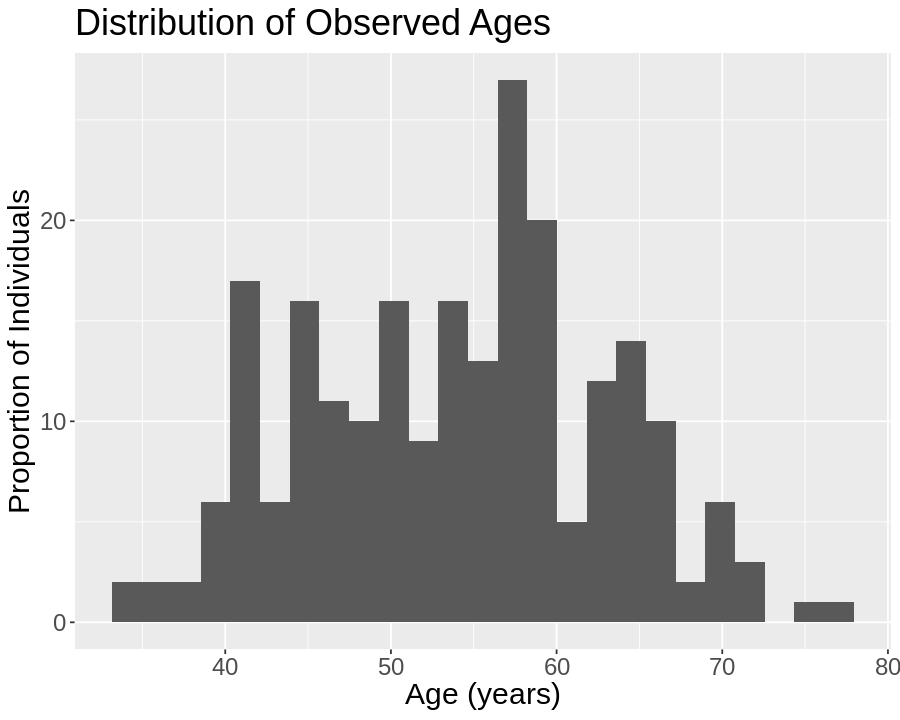

In [11]:
age_dist

*Figure 1: Distribution of observed ages of patients*

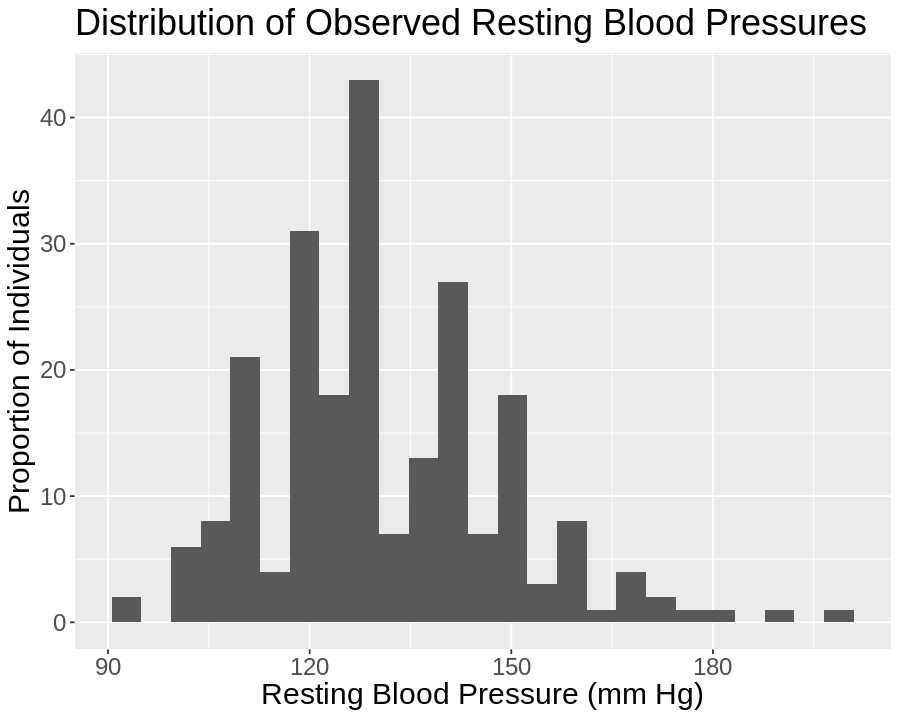

In [12]:
trestbps_dist

*Figure 2: Distribution of observed resting blood pressure of patients*

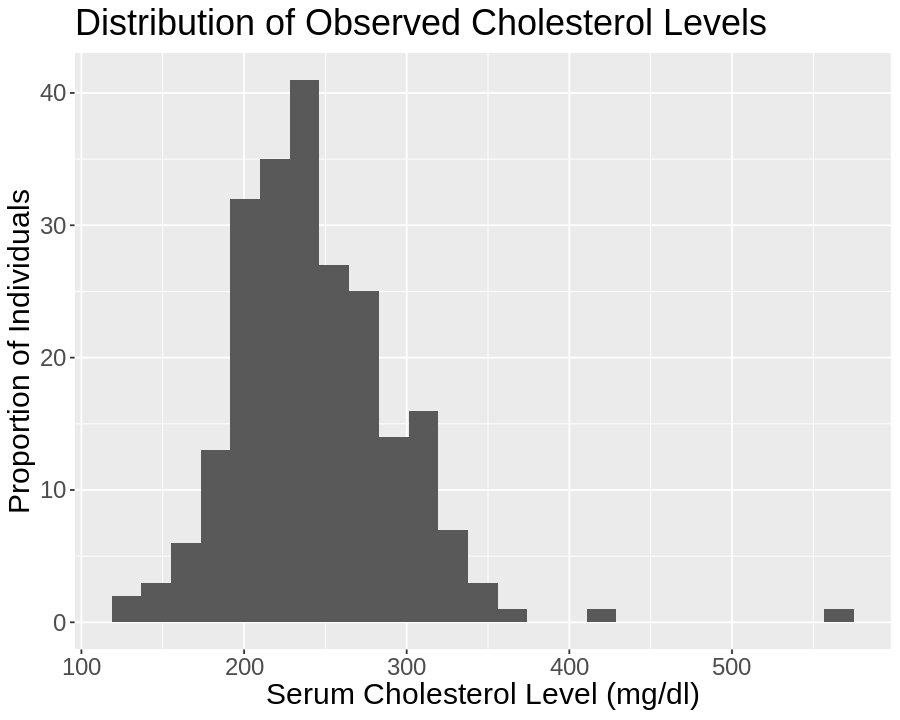

In [13]:
chol_dist

*Figure 3: Distribution of serum cholesterol levels of patients*

From the preliminary analysis, we can see that this dataset has about twice as many males as females, with a mean age of about 55 years old. 

## Training and Tuning the Model

We can now start with our main data analysis. Because we are predicting a categorical variable (whether or not an individual is diagnosed with heart disease), we will use K-NN Classification to conduct our analysis. We start by making the model spec and a recipe, using the training data only. 

To find the optimal value of $k$ that maximizes the accuracy of the model, we'll use 5-fold cross-validation for values of $k$ from 1 to 15.

In [14]:
# main data analysis
# make model spec for knn classification
set.seed(10)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make recipe and standardize data
cleveland_recipe <- recipe(num ~ ., data = cleveland_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# split training data into 5 parts for cross-validation
cleveland_vfold <- vfold_cv(cleveland_training, v = 5, strata = num)

# make workflow
cleveland_workflow <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(knn_spec)

# make tibble with a range of k values
grid_vals <- tibble(neighbors = 1:15)

# tune workflow to test all k values, resample using cross validation data set, collect stats from model
knn_results <- cleveland_workflow |>
    tune_grid(resamples = cleveland_vfold, grid = grid_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# get k value that yields the highest accuracy estimate
k_max_accuracy <- knn_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

k_max_accuracy_acc <- knn_results |>
    arrange(desc(mean)) |>
    slice(1)

k_max_accuracy_acc

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.7046816,5,0.02314094,Preprocessor1_Model11


*Table 7: Tibble of results of training the classifier. We find that $k=11$ produces an accuracy of about 70.5%.*

We can now use this value of $k$ to retrain our classifier and make predictions on our testing data. From there, we can compute the accuracy of the new classifier by computing the ratio of correct predictions to total predictions made.

In [15]:
# make new model spec for the best k
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max_accuracy) |>
    set_engine("kknn") |>
    set_mode("classification")

# retrain classifier
best_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = cleveland_training)

# get predictions on test data
knn_predictions <- best_fit |>
    predict(cleveland_testing) |>
    bind_cols(cleveland_testing)

# get estimate of accuracy of classifier on testing data
knn_accuracy <- knn_predictions |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

knn_accuracy

[1] 0.6973684

We find that our classifier has an accuracy of 69.7%. Given the context of our analysis (using various predictors to accurately predict if a person gets diagnosed with heart disease), we would hope for a classifier with higher accuracy. One way to possibly increase the accuracy of the classifier would be to test how well it predicts ```num``` with fewer predictors, as it's possible that some of them are not as important in predicting heart disease than others. 

For now, we will continue to analyze our classifier with some visualizations. 

In [16]:
# visualizations of age vs. quantitative variables w/ sex and predicted diagnosis
age_vs_trestbps_sex <- knn_predictions |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = age, y = trestbps, colour = .pred_class)) +
        stat_ellipse() +
        geom_point(aes(shape = sex), size = 3) +
        theme(text = element_text(size = 20)) +
        labs(x = "Age (years)", y = "Resting Blood Pressure (mm Hg)", colour = "Predicted Diagnosis", shape = "Sex") +
        scale_color_discrete(labels = c("No Heart Disease", "Heart Disease")) +
        scale_shape_discrete(labels = c("Female", "Male")) +
        coord_flip()

age_vs_chol_sex <- knn_predictions |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = age, y = chol, colour = .pred_class)) +
        stat_ellipse() +
        geom_point(aes(shape = sex), size = 3) +
        theme(text = element_text(size = 20)) +
        labs(x = "Age (years)", y = "Serum Cholesterol Level (mg/dl)", colour = "Predicted Diagnosis", shape = "Sex") +
        scale_color_discrete(labels = c("No Heart Disease", "Heart Disease")) +
        scale_shape_discrete(labels = c("Female", "Male")) +
        coord_flip()

In [17]:
# visualizations of age vs. categorical variables  w/ sex and predicted diagnosis
age_vs_fbs <- knn_predictions |>
    mutate(fbs = as_factor(fbs)) |>
    ggplot(aes(x = age, y = fbs, fill = .pred_class)) +
        geom_boxplot() +
        theme(text = element_text(size = 20)) +
        facet_grid(cols = vars(sex), labeller = labeller(sex = c("0" = "Female", "1" = "Male"))) +
        labs(x = "Age (years)", y = "Fasting Blood Sugar Level > 120 mg/dl", fill = "Predicted Diagnosis") +
        scale_y_discrete(labels = c("No", "Yes")) +
        scale_fill_discrete(labels = c("No Heart Disease", "Heart Disease")) +
        coord_flip()

age_vs_exang <- knn_predictions |>
    mutate(exang = as_factor(exang), sex = as_factor(sex)) |>
    ggplot(aes(x = age, y = exang, fill = .pred_class)) +
        geom_boxplot() +
        theme(text = element_text(size = 20)) +
        facet_grid(cols = vars(sex), labeller = labeller(sex = c("0" = "Female", "1" = "Male"))) +
        labs(x = "Age (years)", y = "Exercise Induced Angina", fill = "Predicted Diagnosis") +
        scale_y_discrete(labels = c("No", "Yes")) +
        scale_fill_discrete(labels = c("No Heart Disease", "Heart Disease")) +
        coord_flip()

options(repr.plot.width = 8, repr.plot.height = 5)

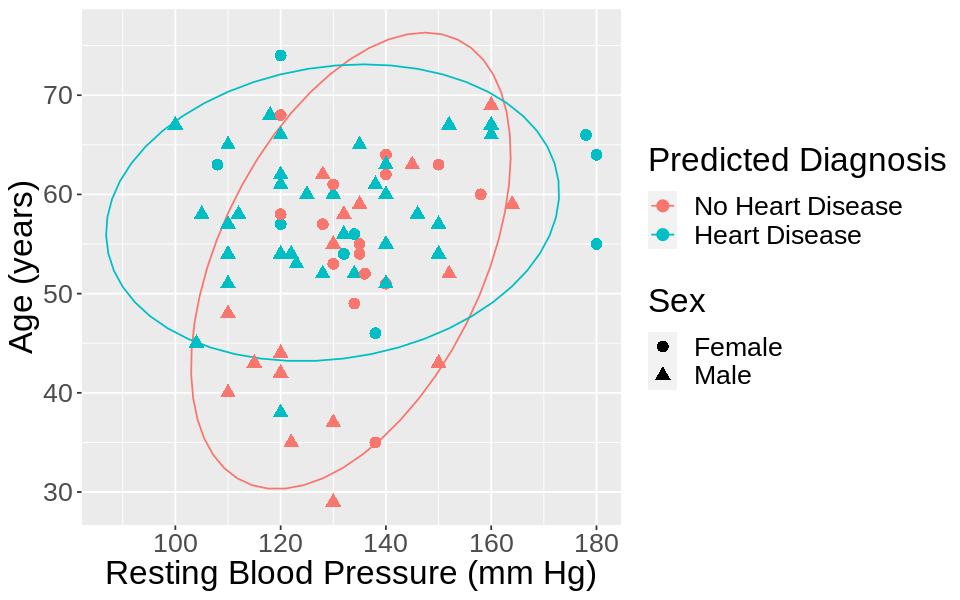

In [18]:
age_vs_trestbps_sex

*Figure 4: Age versus resting blood pressure.*

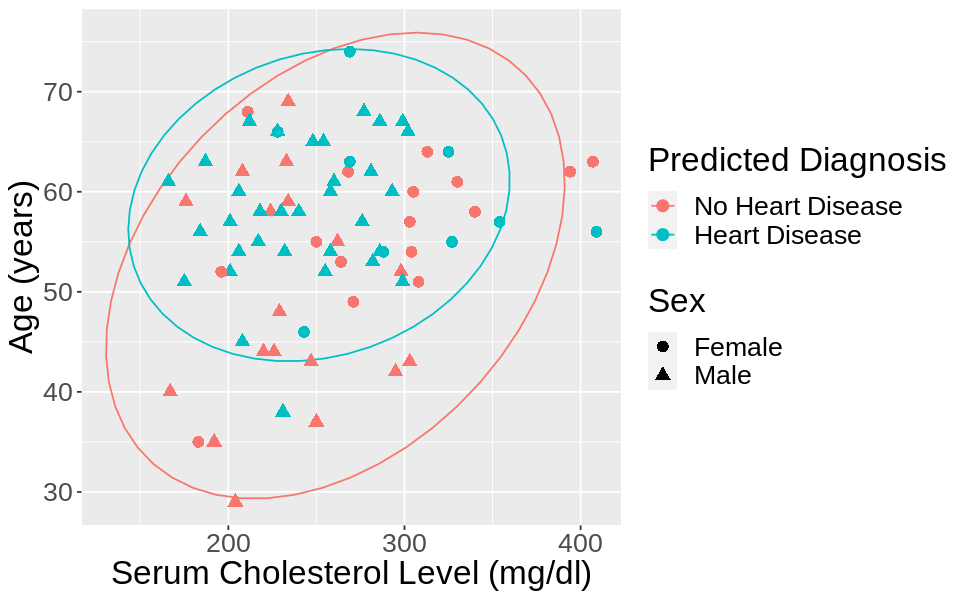

In [19]:
age_vs_chol_sex

*Figure 5: Age versus cholesterol levels.*

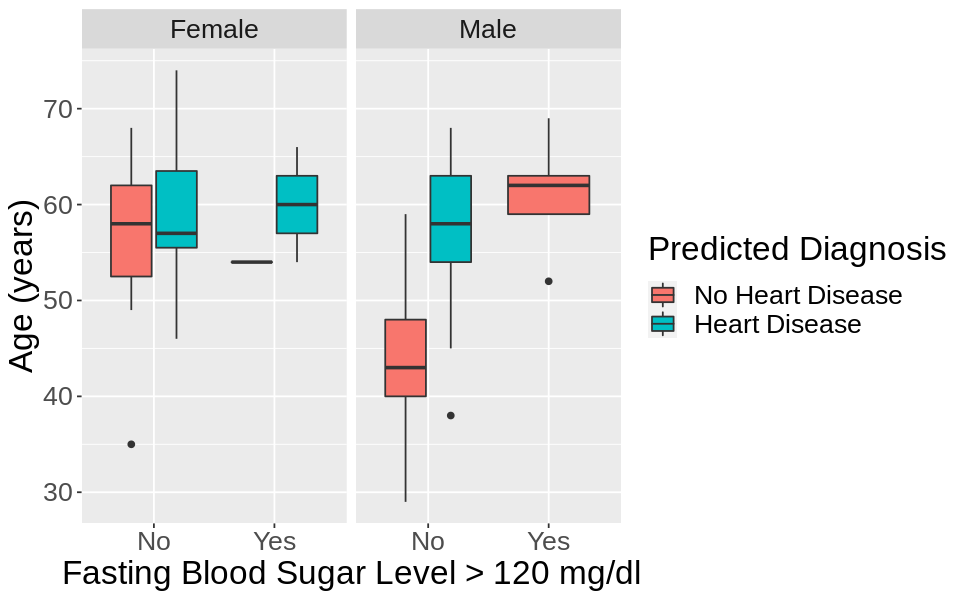

In [20]:
age_vs_fbs

*Figure 6: Age versus whether or not patients have a fasting blood sugar above 120 mg/dl, separated by sex. Boxplots  represent  the  mean  (bold  horizontal  line),  interquartile  range  (boxes),  and  range  (whiskers)  of  age.*

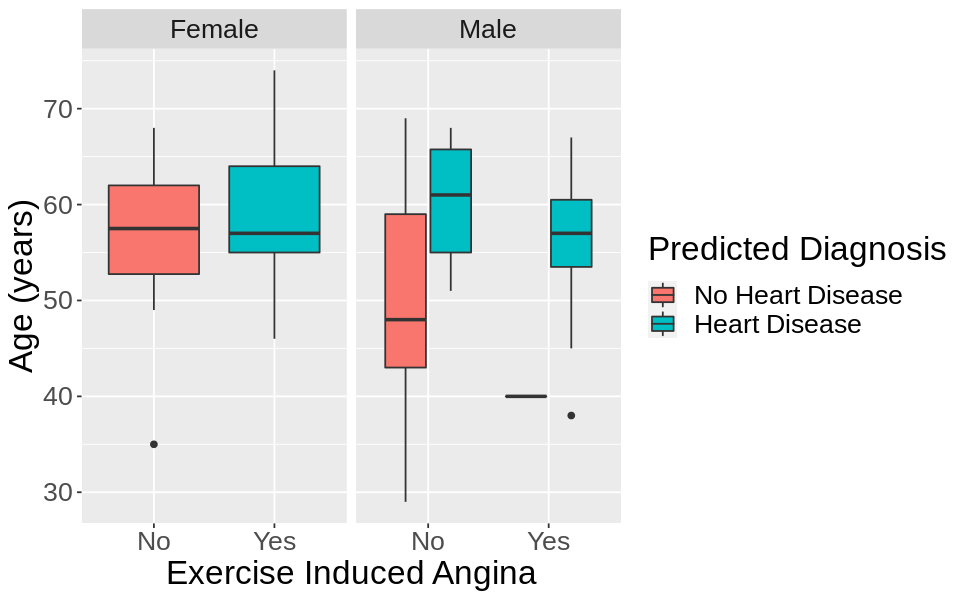

In [21]:
age_vs_exang

*Figure 7: Age versus whether or not patients experience exercise-induced angina, separated by sex. Boxplots  represent  the  mean  (bold  horizontal  line),  interquartile  range  (boxes),  and  range  (whiskers)  of  age.*

In Figure 4, the data points are coloured based on whether or not the individual is expected to have heart disease. We can see from this plot that most of the people predicted to have heart diease are over 40 years old, and have a wide range of resting blood pressure.

From Figure 5, we again see that age seems to have a strong effect on whether or not a person is predicted to have heart disease. We also see that individuals that are predicted to have heart disease have a narrower range of serum blood cholesterol level compared to those who are not predicted to have heart dieases.

The ovals in both Figure 4 and 5 indicate where individuals expected to have heart disease and individuals that are not expected to have heart disease are centered in the data.

Figures 6 and 7 show boxplots demonstrating the mean ages of people who are and aren't predicted to have heart disease, and whether or not they have a fasting blood sugar above 120 mg/dl, and whether or not they experience exercise-induced angina. We see a few interesting things from these two figures: Females who have a fasting blood sugar above 120 mg/dl or males who did experience exercise-induced angina are not predicted to not have heart disease. In other words, women with blood sugar above 120 mg/dl or men who experience exercise-induced angina are all predicted to have heart disease.

We can also see from Figures 6 and 7 the mean ages of men and women who are predicted to have heart disease based on their fasting blood sugar and susceptibility to exercise-induced angina:
* Women with a fasting blood sugar above 120 mg/dl who are predicted to have heart disease have a mean age of around 60 years old
* Men with a fasting blood sugar above 120 mg/dl who are predicted to have heart disease have a mean age of around 58 years old
* Women who experience exercise-induced angina who are predicted to have heart disease have a mean age of around 57 years old
* Men who experience exercise-induced angina who are predicted to have heart disease have a mean age of around 57 years old


## Discussion

#### Summary

With multiple variables, including age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas, being used in our model to predict the probability of having heart disease, several results have been found. 


* In the cases where we looked at resting blood pressure and serum cholesterol levels, there was little correlation between an increase in blood pressure and cholesterol levels and an increase in getting heart disease. When factoring age into the data, it can be seen that patients above 40 in both graphs are at higher risk of heart disease, while gender does not play a significant role. 
* When exercise-induced angina is present (chest pains during physical activity or emotional distress), heart disease is slightly more likely to occur.
* When observing the variables of exercise-induced angina and fasting blood sugar levels, we found that gender does play a role in the likelihood of heart disease. Males with higher blood sugar levels were predicted to have a lower risk of heart disease, while females with higher blood sugar levels were likelier to have heart disease than those with lower blood sugar levels. Furthermore, both males and females who experienced exercise-induced angina were predicted to have heart disease. While all females that did not have exercise-induced angina were not predicted to have heart disease, males who did not experience exercise-induced angina were predicted to have heart disease, with an increase in age. 
* In all these models, age is a standard variable responsible for the increased risk of heart disease, as there becomes an increased risk among patients in the older age categories.


To summarize, our model found age as the most significant variable in predicting heart disease. While cholesterol levels, and resting blood pressure, by themselves, had less of an effect on predicting heart disease. Gender and age with fasting blood sugar levels and exercise-induced angina variables also showed correlations that could be used to predict heart disease. 


Our model has around a 69.7% accuracy rate, indicating a moderate predictive performance level. Predictive performances are often dependent on the type of model that we are predicting from. While 69.7% may be an alright performance for some models, in this specific context of predicting heart disease, we would ideally want a more accurate prediction to ensure that our results reflect the likelihood of someone getting heart disease. A correct prediction, in our case, would have a significant impact on real-life scenarios of the patient being diagnosed in our case.  


#### Expectations

Compared with our original predictions, the results of this study vary, with each variable having a different impact. All variables being tested were expected to correlate with an increased risk of heart disease. And while this was true for some variables, such as age, other variables did not have as strong of a correlation as previously predicted. In contrast, exercise-induced angina and fasting blood sugar levels strongly predicted the likelihood of heart disease among genders. We also predicted that resting blood sugar rates and serum cholesterol levels would have a stronger correlation to the increased risk of heart disease; however, the correlation was much weaker than predicted, although when plotted with age, a slight correlation occurred. 


#### Impact of Findings

Our projects findings, through the prediction of heart disease using a binary classification model, can potentially have a significant impact, despite the current limitations of our classifier. While our model shows promise, further improvements are necessary in order to enhance the overall accuracy. However, despites these challenges, our findings still offer valuable insights into the potential benefits. For one, accurate prediction of heart disease based on our predictor variables allows for earlier intervention, potentially saving the lives of many at-risk individuals. Early diagnosis of the existence of heart disease, in particular, allows for timely medical attention, possibly contributing to improved health outcomes and lower mortality rates. Furthermore, these findings could help healthcare professionals utilize resources more effectively, ensuring that interventions, such as medications, are only given to individuals who require them. Specifically, healthcare systems can be more efficient with their resources and make treatments more accessible by taking this targeted approach. Finally, through the utilization of these predictor variables and their impact on heart disease, individuals may become more aware of their health and potential risk factors. Thus, individuals may be more encouraged to maintain healthier lives, such as eating a balanced diet and engaging in regular physical activity, as a result of enhanced awareness.

#### Future Questions

Overall, the findings from our project inspire further research and questions. To begin, while our study revealed that multiple predictor variables were linked to heart disease, diving deeper into the underlying mechanism between these variables and heart disease may be necessary for greater comprehension. Furthermore, future research could look into additional factors that may promote such disease, such as environmental and socioeconomic factors. For example, being able to investigate an extensive range of predictor factors may allow for the construction of a more accurate model capable of understanding the complexities surrounding heart disease development. Lastly, future research could explore the generalizability of our findings on more diverse populations. For instance, since our data was pulled from a Cleveland dataset, the exploration of other demographics could potentially enhance the applicability of our findings to more individuals.


## References

Centers for Disease Control and Prevention. “Heart Disease and Stroke.” Www.cdc.gov, 7 Oct. 2020, www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart.

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Public Health Agency of Canada. (2022, July 28). Heart Disease in Canada. Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html